# Advanced feature eng with keras

following this https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/feature_engineering/solutions/4_keras_adv_feat_eng.ipynb

In [1]:
import datetime
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow.keras import models

# set TF error log verbosity
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.version.VERSION)

2.5.0


## Create input pipeline
Typically, you will use a two step process to build the pipeline. Step one is to define the columns of data; i.e., which column we're predicting for, and the default values. Step 2 is to define two functions - a function to define the features and label you want to use and a function to load the training data. Also, note that pickup_datetime is a string and we will need to handle this in our feature engineered model.

In [2]:

CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key',
]
LABEL_COLUMN = 'fare_amount'
STRING_COLS = ['pickup_datetime']
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count']
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

In [3]:
def features_and_labels(row_data, discard_keys = []):
    for unwanted_col in discard_keys:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label

# A utility method to create a tf.data dataset from a Pandas Dataframe
def load_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(pattern,
                                                    batch_size,
                                                    CSV_COLUMNS,
                                                    DEFAULTS)
    dataset = dataset.map(features_and_labels)  # features, label
    if mode == 'train':
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

In [4]:
# Create a Baseline DNN Model in Keras 

# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    # input layer
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # feature_columns
    feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs, output)

    # compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

    return model

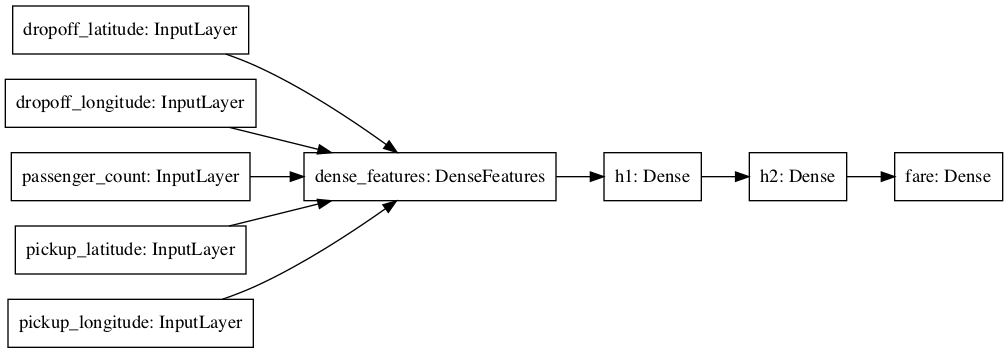

In [5]:
model = build_dnn_model()

# We can visualize the DNN using the Keras `plot_model` utility.
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [6]:
TRAIN_BATCH_SIZE = 32 
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 14906
DATA_PATH = './data/taxi_data/'

In [7]:
# `load_dataset` method is used to load the dataset.
trainds = load_dataset(DATA_PATH + 'taxi-train*',
                       TRAIN_BATCH_SIZE,
                       'train')

evalds = load_dataset(DATA_PATH + 'taxi-valid*',
                      1000,
                      'eval').take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# `Fit` trains the model for a fixed number of epochs
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['pickup_datetime', 'key'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1863/1863 [==============================] - 3s 1ms/step - loss: 109.0858 - rmse: 9.7139 - mse: 109.0858 - val_loss: 101.5228 - val_rmse: 10.0622 - val_mse: 101.5228
Epoch 2/5
1863/1863 [==============================] - 2s 893us/step - loss: 102.7681 - rmse: 9.5589 - mse: 102.7681 - val_loss: 99.1910 - val_rmse: 9.9203 - val_mse: 99.1910 - loss: 102.9495 - rmse: 9.5667 - mse: 102.94
Epoch 3/5
1863/1863 [==============================] - 2s 962us/step - loss: 104.1508 - rmse: 9.6386 - mse: 104.1508 - val_loss: 100.7078 - val_rmse: 10.0004 - val_mse: 100.7078
Epoch 4/5
1863/1863 [==============================] - 2s 943us/step - loss: 105.7886 - rmse: 9.6816 - mse: 105.7886 - val_loss: 99.8074 - val_rmse: 9.9740 - val_mse: 99.8074
Epoch 5/5
1863/1863 [==============================] - 2s 935us/step - loss: 100.6703 - rmse: 9.4851 - mse: 100.6703 - val_loss: 99.8103 - val_rmse: 9.9637 - val_mse: 99.8103


In [8]:
# A function to define plot_curves.
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

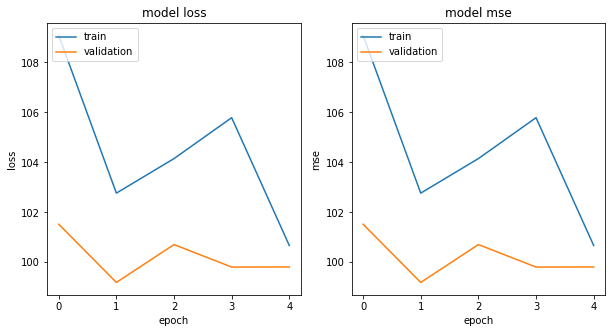

In [9]:
plot_curves(history, ['loss', 'mse'])


In [10]:
# prediction for a custom datapoint

# Use the model to do prediction with `model.predict()`.
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['pickup_datetime'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


array([[11.398858]], dtype=float32)

# Improve Model Performance Using Feature Engineering¶
We now improve our model's performance by creating the following feature engineering types: Temporal, Categorical, and Geolocation


We incorporate the temporal feature pickup_datetime. As noted earlier, pickup_datetime is a string and we will need to handle this within the model. First, you will include the pickup_datetime as a feature and then you will need to modify the model to handle our string feature.